## Optimization exploration
We want the thermalization to go as fast as possible.

In [1]:
using BenchmarkTools

In [2]:
function takeHalf(A::Array{Float64, 1})
    return A[1:20]
end
function takeHalf2(A::Array{Float64, 1})
    return A
end

takeHalf2 (generic function with 1 method)

In [3]:
A = rand(50)
@benchmark takeHalf(A)

BenchmarkTools.Trial: 
  memory estimate:  240 bytes
  allocs estimate:  1
  --------------
  minimum time:     52.525 ns (0.00% GC)
  median time:      59.956 ns (0.00% GC)
  mean time:        68.494 ns (8.35% GC)
  maximum time:     2.485 μs (90.42% GC)
  --------------
  samples:          10000
  evals/sample:     987

In [4]:
@benchmark takeHalf2(A)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     17.261 ns (0.00% GC)
  median time:      17.573 ns (0.00% GC)
  mean time:        17.796 ns (0.00% GC)
  maximum time:     39.233 ns (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     998

In [5]:
@benchmark e = Array{Float64, 1}(10000)

BenchmarkTools.Trial: 
  memory estimate:  78.20 KiB
  allocs estimate:  2
  --------------
  minimum time:     842.011 ns (66.62% GC)
  median time:      894.920 ns (66.95% GC)
  mean time:        1.156 μs (73.76% GC)
  maximum time:     119.121 μs (99.32% GC)
  --------------
  samples:          7057
  evals/sample:     611

In [6]:
@benchmark e = zeros(10000)

BenchmarkTools.Trial: 
  memory estimate:  78.20 KiB
  allocs estimate:  2
  --------------
  minimum time:     10.421 μs (0.00% GC)
  median time:      14.339 μs (0.00% GC)
  mean time:        16.987 μs (12.97% GC)
  maximum time:     799.650 μs (90.54% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [7]:
function nArray(n::Int64)
    return [i for i = 1:n]
end
E = zeros(10000)
n = 5
for i = 1:20
    E[(i-1)*n+1:i*n] = nArray(n)
end

In [8]:
function arrayMap()
    L = 10000
    E = Array{Int64,1}(L)
    n = 5
    N = floor(Int64, L/n)
    for i = 1:N
        E[(i-1)*n+1:i*n] = nArray(n)
    end
    return E
end
function arrayMap2()
    L = 10000
    n = 5
    N = floor(Int64, L/n)
    E = nArray(n)
    for i = 2:N
        E = vcat(E, nArray(n))
    end
    return E
end
        

arrayMap2 (generic function with 1 method)

In [9]:
arrayMap2() == arrayMap()

true

In [10]:
@benchmark arrayMap()

BenchmarkTools.Trial: 
  memory estimate:  328.20 KiB
  allocs estimate:  2002
  --------------
  minimum time:     82.816 μs (0.00% GC)
  median time:      88.874 μs (0.00% GC)
  mean time:        105.282 μs (11.43% GC)
  maximum time:     1.416 ms (73.01% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [11]:
@benchmark arrayMap2()

BenchmarkTools.Trial: 
  memory estimate:  76.80 MiB
  allocs estimate:  5590
  --------------
  minimum time:     17.461 ms (12.19% GC)
  median time:      18.254 ms (15.20% GC)
  mean time:        18.473 ms (15.17% GC)
  maximum time:     89.144 ms (81.71% GC)
  --------------
  samples:          271
  evals/sample:     1

# Importing and testing parallelization thermilization

In [1]:
# Import source

cd("../Source")
@everywhere include("ChiralMC.jl")
@everywhere using ChiralMC

@everywhere include("functions_msc.jl")
@everywhere include("functions_observables.jl")
@everywhere include("functions_parallel.jl")

using Base.Test
using Plots
pyplot()
using Distributions
cd("../Notebooks/")

In [2]:
@everywhere const two_pi = 2π

# We run a simulation with the parameters
g = 0.3    # Gauge coupling
ν = 0.3    # Anisotropy
H = -0.72   # External field

# Other parameters
L = 64     # System length
T = 0.12   # Temperature
γ = 1.0    # Order parameter amplitud

# Calculate periodic boundary conditioned f s.t. fL ∈ N
f = ceil(abs(H/(2π)*L))/L*sign(H)
println("f set to $(f)")
# Calculate inverse temperature
β = 1/T
println("β set to $(β)")

# Create system
syst = SystConstants(L, γ, 1/g^2, ν, f, β)
sim = Controls(π/3, 0.4, 3.0)

# Measurement parameters
M = 100    # Number of measurements
Δt = 400  # Interval between measurements (MCS)
# Construct k-matrix where the horizontal axis contains kx ∈ [-π, π), while
# the vertical axis contain ky ∈ [-π, π) at the second component
k_matrix = [[2π/L*(x-1-L/2), 2π/L*(L/2-y)] for y=1:L, x=1:L];

f set to -0.125
β set to 8.333333333333334


In [3]:
include("../Source/functions_plots_and_files.jl")

initializeParallelStatesS (generic function with 1 method)

In [4]:
(t₀, ψ_ref, sim_ref, ψ_w, sim_w) = initializeParallelStatesS(syst, sim);

Thermalizing 3 states
Number of parallel workers: 2
Increasing simulation time such that tₛ = 1001 and T = 1802
Increasing simulation time such that tₛ = 1802 and T = 3244
Increasing simulation time such that tₛ = 3244 and T = 5840
Worker 1 initially thermalised after 4930 steps
Worker 2 initially thermalised after 5026 steps
All workers initially thermalized after 5026 steps
Thermalization successful between T = [5841, 8840]
Worker 1: ΔE = 5.70990470620046e-5 ± 0.004694964189845423
Worker 2: ΔE = 0.00010113354432027448 ± 0.0044951059576514435
Final thermalization time: 19600
341.685975 seconds (772.70 M allocations: 24.946 GiB, 2.22% gc time)
Calculating energies and acceptance rates
Saving plots to files


In [34]:
# Make reference states and high energy states.
n_workers = nprocs()-1
ψ_ref = State(2, syst)
ψ_list = [State(1,syst) for i = 1:n_workers];

In [35]:
@time t₀, E_ref, E_w, ψ_ref, ψ_w, sim_ref, sim_w = parallelThermalization!(ψ_ref, ψ_list, syst, sim);

Number of parallel workers: 2
Increasing simulation time such that tₛ = 1001 and T = 1802
Worker 1 initially thermalised after 1408 steps
Worker 2 initially thermalised after 1403 steps
All workers initially thermalized after 1408 steps
Thermalization successful between T = [1803, 4802]
Worker 1: ΔE = 0.00015013473850476926 ± 0.022797160478114455
Worker 2: ΔE = 0.0008446235093643846 ± 0.02191507070193102
Final thermalization time: 12282
 18.378814 seconds (37.15 M allocations: 1.370 GiB, 3.92% gc time)


In [36]:
pyplot()

Plots.PyPlotBackend()

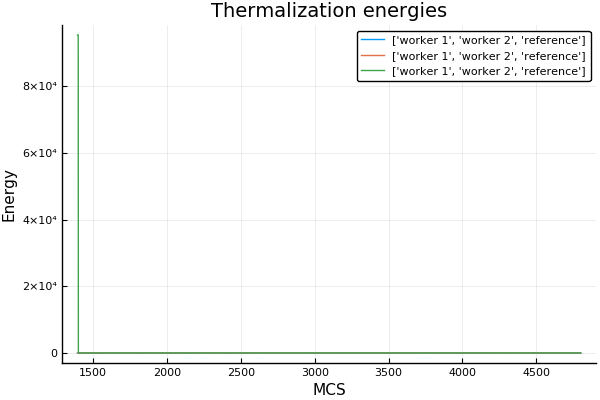

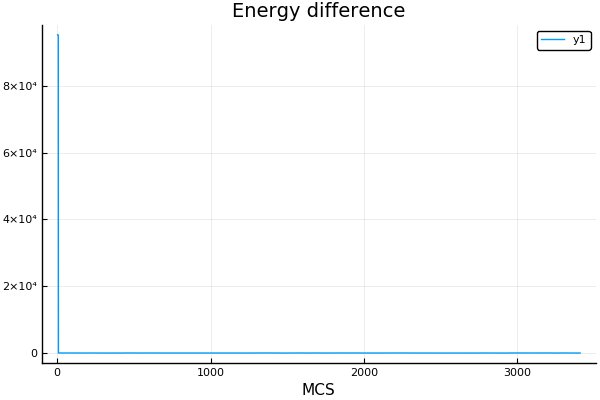

1393


In [48]:
# Plot the last PLOT_FRACTION fraction of the energy intervals
PLOT_FRACTION = 0.71
N = length(E_ref)
tₛ = N - floor(Int64, N*PLOT_FRACTION)
#tₛ = 1300
#N = 1399
println(tₛ)
int = tₛ:N
n_workers == size(E_w,1) || throw(error("ERROR: Somehow the number of workers changed during thermalization"))

# Converting the misc. energies into an array of arrays of energies
energies = Array{Array{Float64, 1}, 1}(n_workers+1)
labels = Array{String, 1}(n_workers+1)
energies[n_workers+1] = E_ref[int]
labels[n_workers+1] = "reference"
for w = 1:n_workers
    energies[w] = E_w[w,int]
    labels[w] = "worker $(w)"
end

# Plotting the energies of reference and all workers
plt = plot(int, energies, label=labels, xlabel="MCS", ylabel="Energy", title="Thermalization energies");
display(plt)

# Plot energy difference for first worker
dE = E_ref[int] - E_w[1,int]
plt = plot(1:length(dE), dE, title="Energy difference", xlabel="MCS");
display(plt)



In [5]:
t₀

13604

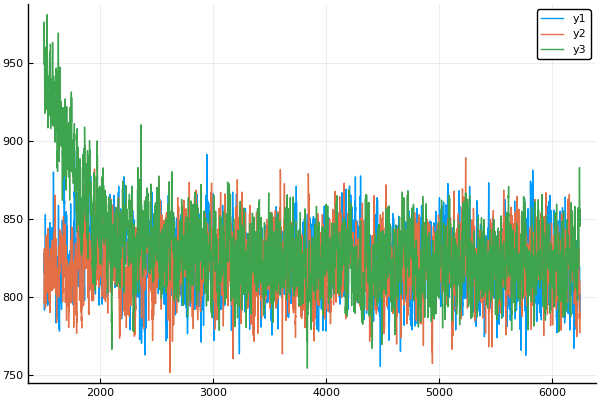

In [12]:
start = 1500
plt = plot(E_ref[start:end])
n_workers = size(E_w,1)
y = Array{Array{Float64,1},1}(n_workers+1)
y[n_workers+1] = E_ref[start:end]
for w = 1:n_workers
    y[w] = E_w[w, start:end]
end
plot(start:length(E_ref), y)

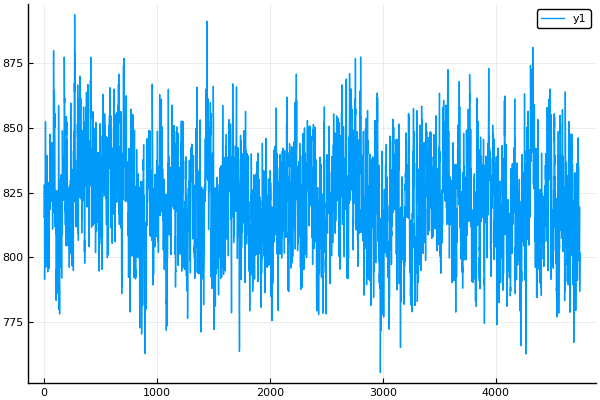

In [13]:
plot(E_w[1,start:end])

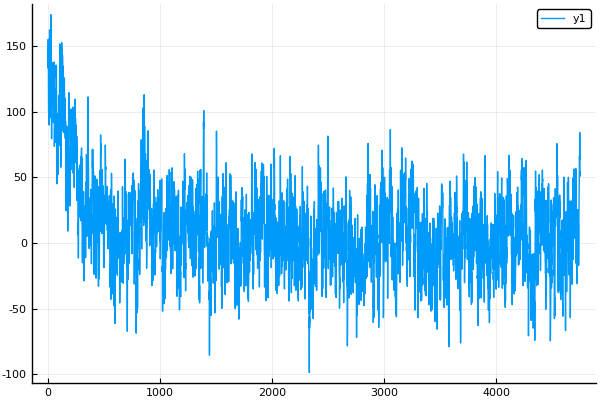

In [14]:
plot(E_ref[start:end]-E_w[1,start:end])

In [21]:
ψ_ref.lattice[1,1].u⁺^2+ψ_ref.lattice[1,1].u⁻^2

0.7595557261840739

In [5]:
ψ_list = vcat(ψ_w, [ψ_ref]);
@time av_V⁺, err_V⁺, V⁺, av_V⁻, err_V⁻, V⁻, av_S⁺, err_S⁺, S⁺, av_S⁻, err_S⁻, S⁻ = parallelSFVLA!(k_matrix, ψ_list, sim_ref, M, t₀)

Starting 100 measurements on 3 processes doing max 34 measurements each
on a 64×64 system.
Measurement progress: 30%
Measurement progress: 70%
Measurement progress: 100%
Measurements done, collecting parallell results.
Parallell measurements done. Processing.

Sum of vorticity of random snapshot:
V⁺: 	-512.0000000000001
V⁻: 	-512.0000000000001

Max (S⁺, S⁻)
(1.000000000000001, 1.0000000000000018)
Max δ(S⁺, S⁻)
(9.260618719944721e-5, 4.721035105590745e-5)
Max correlation time
(18.305819269683592, 19.090655734696057)
11203.372828 seconds (37.28 G allocations: 1.192 TiB, 3.68% gc time)


([-0.159958 -0.117945 … -0.000457285 -0.159534; -0.0503057 -0.0700968 … -0.180583 -0.120819; … ; -0.13927 -0.101801 … -0.150481 -0.158071; -0.139952 -0.109256 … -0.199304 -0.0804984], [0.0118335 0.0144863 … 0.0158363 0.0114137; 0.0159596 0.0186029 … 0.0247752 0.0138984; … ; 0.017226 0.012085 … 0.01388 0.0116079; 0.0120981 0.015771 … 0.0109246 0.0141123], Array{Float64,2}[[-0.0236883 -0.00111387 … 0.994436 -0.996544; 0.0117714 0.999895 … -1.00899 -0.00342643; … ; -0.995723 -0.0120744 … 0.00648594 -0.00986121; -0.0101564 -0.00280403 … -0.000605167 0.999421], [-0.00329491 -0.996643 … 0.00383152 0.00856477; 0.00841571 0.999191 … -1.02583 -0.977492; … ; -1.0066 1.00615 … -0.999059 0.011924; 0.0194649 -0.00117391 … -0.00563872 -0.0156835], [0.00647012 0.0049307 … -0.0249573 0.00180917; -0.981192 -0.0338104 … -0.975381 -0.00713225; … ; -1.00413 -0.00763122 … 1.00805 -0.00140893; 1.00375 -1.02481 … -1.01732 -0.0131463], [0.994342 -1.02199 … 1.00702 -1.00104; -0.998624 1.00362 … -0.98901 0.9990

In [6]:
plotStructureFunctionVortexLatticeS(av_V⁺, av_V⁻, V⁺[rand(1:M)], V⁻[rand(1:M)], av_S⁺, av_S⁻, k_matrix)

S⁺(0) ≈ 1.000000000000001
S⁻(0) ≈ 1.0000000000000018
The proportion of vortices (n⁺, n⁻) in snapshot
% of vortex kind (-1, -1): 	6
% of vortex kind (-1, 0): 	19
% of vortex kind (-1, 1): 	2
% of vortex kind (0, -1): 	12
% of vortex kind (0, 0): 	42
% of vortex kind (0, 1): 	5
% of vortex kind (1, -1): 	3
% of vortex kind (1, 0): 	10
% of vortex kind (1, 1): 	1

Sum of + component vorticity in the snapshot: -512.0000000000015
Sum of - component vorticity in the snapshot: -512.0000000000009


1

In [7]:
length(S⁺)

100

In [49]:
m_max = 14
PROG_NUM = 10
prog_int = floor(Int64, m_max/(PROG_NUM))
println("prog_int = $(prog_int)")
count = 0
for m = 2:m_max
    if m % prog_int == 0
        println("Measurement progress: $(Int(round(m/m_max*100,0)))%")
        count += 1
    end
    flush(STDOUT)
end
println("Total number of prints: $(count)")

prog_int = 1
Measurement progress: 14%
Measurement progress: 21%
Measurement progress: 29%
Measurement progress: 36%
Measurement progress: 43%
Measurement progress: 50%
Measurement progress: 57%
Measurement progress: 64%
Measurement progress: 71%
Measurement progress: 79%
Measurement progress: 86%
Measurement progress: 93%
Measurement progress: 100%
Total number of prints: 13
